## Predicting uncertainty with (deep) neural networks - Non gaussian distributions

**NOTE**: This notebook has been adapted from the original version : https://github.com/sthorn/deep-learning-explorations/blob/master/predicting-uncertainty.ipynb*

### Selected Distribution - Standard Exponential

In this notebook we will play with a different noise distribution: Standard Exponential. We have seen that the technique Exp.I accomodates the loss function to estimate a gaussian distribution with two parameters: mean and variance. Here, we will try to answer the main question:

> **H1**: Should we change the loss function if we know that the noise distribution is not gaussian? What is the effect of having a 'gaussian loss function'?
*This hypothesis will be validated with Experiment.I*

Additionally, we will use an exponential noise because it is an assymetric distribution (the positive and negative variance of y for each xi is not the same). On the other side, as we have seen in 'custom_loss_error' experiments, the technique works when there is a constant covariance over time (conclusions Experiment 3). Based on these facts, we formulate the folllowing two hypothesis:

> **H2**: Are we able to approximate an assymetric error distribution such as Standard Exponential? 

> **H3**: Are we able to approximate a non-constant covariance of the uncertainty and the target? 

### Imports 

In [1]:
import numpy as np
np.random.seed(2019)
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import statistics as stat

%matplotlib inline

### Utilities

#### Custom loss function

In [2]:
def loss_variance_error(input, target):
    
    # Estimate target value for variance (sigma^2) with (y_pred - y)**2
    #
    #    actual y        is target[:,0]
    # predicted y        is input[:,0]
    #    actual variance is target[:,1] - estimated here
    # predicted variance is input[:,0]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data)**2, 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

#### Model definition

In [3]:
# Here, parameters are common for all experiments
input_size = 1
output_size = 2
hidden_size = 1000

# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
class TwoLayer_Network(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayer_Network, self).__init__()
        self.l1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.l3 = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        linear_1 = self.l1(x)
        h_relu = self.relu(linear_1)
        y_pred = self.l3(h_relu)
        return y_pred

#### Prepare data for training

In [4]:
def data_preparation(x, y, n_validation=500):
    # Add in column of dummy zeros to represent sigma 
    sigma = np.zeros(y.size)
    y = np.stack([y, sigma], axis=1)
    x = x.reshape(x.size, 1)
    
    # Split into training and validation sets
    x_val, x = x[:n_validation], x[n_validation:]
    y_val, y = y[:n_validation], y[n_validation:]
    
    return  x_val, x,  y_val, y

#### Visualization utilities

In [5]:
def plot_regression_dataset(x, y, y_1, title_txt):   
    # Plot the data
    plt.figure(figsize=(14,6))
    plt.title(title_txt)

    plt.plot(x, y_1, '.', alpha=0.2, color='black' ) 
    plt.plot(x, y, '.', alpha=0.2, color='green' ) 

    plt.xlabel(r'$x$');
    plt.ylabel(r'$y$');
    plt.show()

In [6]:
def plot_regression_uncertainty(x_val, y_val, y_pred, sigma_pred, real_sigma):  
    # Plot predictions and their errors
    fig, ax1 = plt.subplots(figsize=(14,6))
    plt.title('Estimated uncertainty in predictions')

    ax1.plot(x_val, y_val[:,0], '.', color='purple')
    ax1.errorbar(x_val, y_pred, yerr=np.sqrt(sigma_pred) , color='green', fmt='.'); 
    ax1.errorbar(x_val, y_pred, yerr=np.sqrt(real_sigma) ,linewidth=0.5, color='grey', fmt='.'); 

    # One standard-deviation envelope
    plt.xlabel(r'$x$');
    plt.ylabel(r'$y$');
    plt.title('Validation set predictions');
    plt.legend([r'Original data', 'Predicted sigma in predictions', 'Real sigma in predictions'], loc='upper left', );

### Experiment I

> **H1**: Should we change the loss function if we know that the noise distribution is not gaussian? What is the effect of having a 'gaussian loss function'? This hypothesis will be validated with Experiment.I

#### Generate some random data

We generate random exponential noise in both directions of the target function. Additionally, we increment the number of cycles to 5

In [7]:
# Generate some linearly related data
n_samples = 10000
x = np.random.random(n_samples)

sin_ = 0.4 * np.sin(x*5*np.pi)
eps = np.random.standard_exponential(size=n_samples) * sin_  +  np.random.standard_exponential(size=n_samples) * - sin_# noise
y_1 = 2*x + 1 
y = y_1 + eps # linear data with noise

#### Describe the generated data

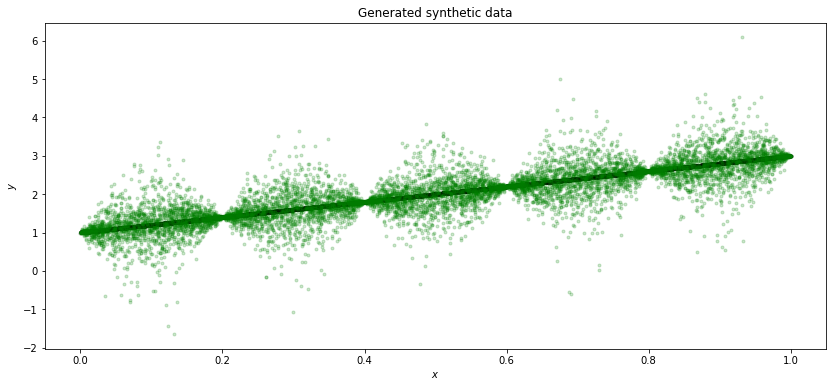

In [8]:
# Plot the data
plot_regression_dataset(x, y, y_1, 'Generated synthetic data')

#### Prepare the dataset and split in train and test

In [9]:
x_val, x,  y_val, y = data_preparation(x, y, n_validation=500)

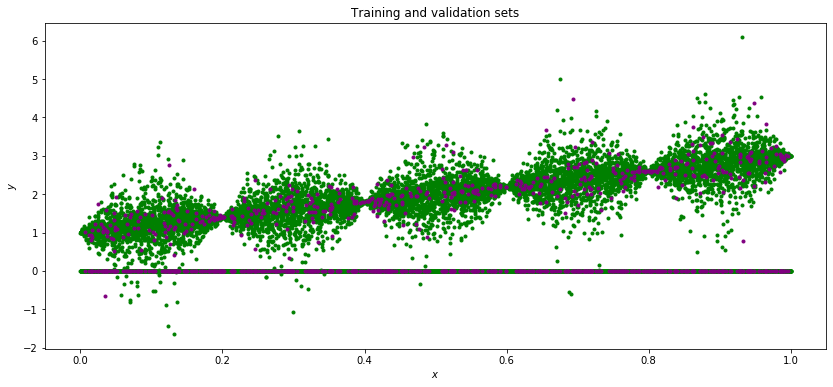

In [10]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Training and validation sets')
plt.plot(x, y, '.', color= 'green')
plt.plot(x_val, y_val, '.', color='purple')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [11]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.cuda.FloatTensor
x_t = Variable(torch.from_numpy(x).type(dtype))
y_t = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x_t.shape, y_t.shape

(torch.Size([9500, 1]), torch.Size([9500, 2]))

#### Create a simple network 

In [12]:
model_1 = TwoLayer_Network(input_size, hidden_size, output_size).cuda()

In [13]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

#### Training loop 
We train this simple model with batch size equal to the whole dataset. Here, we use 'loss_variance_error' function

In [14]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model_1(x_t)
    
    # Calculate loss
    loss = loss_variance_error(y_pred, y_t)
    if i%500 == 0: print(f'epoch: {i:4} loss: {loss.data.item():.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0 loss: 12.3
epoch:  500 loss: 0.177
epoch: 1000 loss: 0.177
epoch: 1500 loss: 0.177
epoch: 2000 loss: 0.176
epoch: 2500 loss: 0.176
epoch: 3000 loss: 0.176
epoch: 3500 loss: 0.176
epoch: 4000 loss: 0.176
epoch: 4500 loss: 0.175
epoch: 5000 loss: 0.175
epoch: 5500 loss: 0.175
epoch: 6000 loss: 0.175
epoch: 6500 loss: 0.174
epoch: 7000 loss: 0.174
epoch: 7500 loss: 0.174
epoch: 8000 loss: 0.174
epoch: 8500 loss: 0.173
epoch: 9000 loss: 0.173
epoch: 9500 loss: 0.173


#### Get predictions for validation set 

In [15]:
# Get predicted y and sigma for validation set
x_val_t = Variable(torch.from_numpy(x_val).type(dtype)) 
pred_1 = model_1(x_val_t)
# prediction of the response variables
y_pred_1 = pred_1[:,0].cpu().data
sigma_pred_1 = pred_1[:,1].cpu().data

In [16]:
real_sigma_1 = (y_pred_1.numpy()- y_val[:,0])**2

C:\Users\yolan\Anaconda3\envs\deep_learning_pytorch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


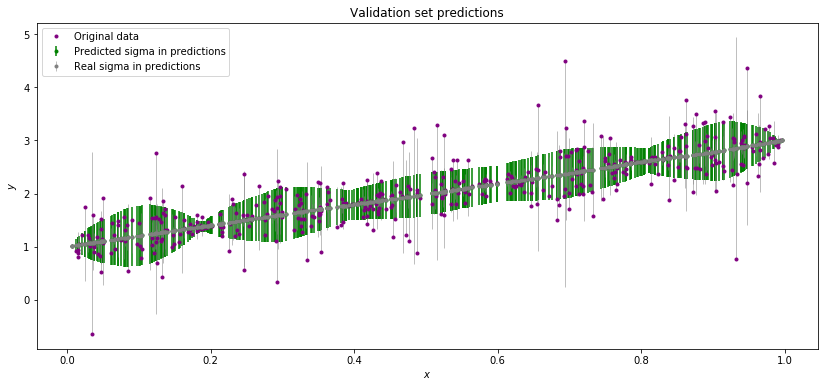

In [17]:
plot_regression_uncertainty(x_val, y_val, y_pred_1, sigma_pred_1, real_sigma_1)

### Experiment II

> **H2**: Are we able to approximate an assymetric error distribution such as Standard Exponential? 

In [18]:
# Generate some linearly related data
n_samples = 10000
x = np.random.random(n_samples)

sin_ = 0.4 * np.sin(x*5*np.pi)
eps = np.random.standard_exponential(size=n_samples) * sin_  
y_1 = 2*x + 1 
y = y_1 + eps # linear data with noise

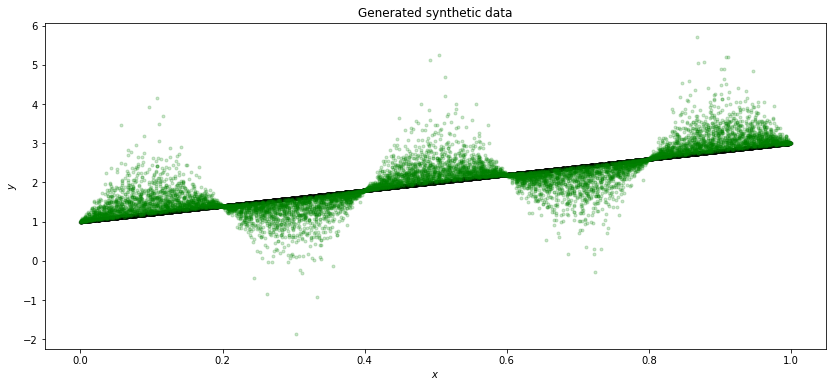

In [19]:
# Plot the data
plot_regression_dataset(x, y, y_1, 'Generated synthetic data')

In [20]:
x_val, x,  y_val, y = data_preparation(x, y, n_validation=500)

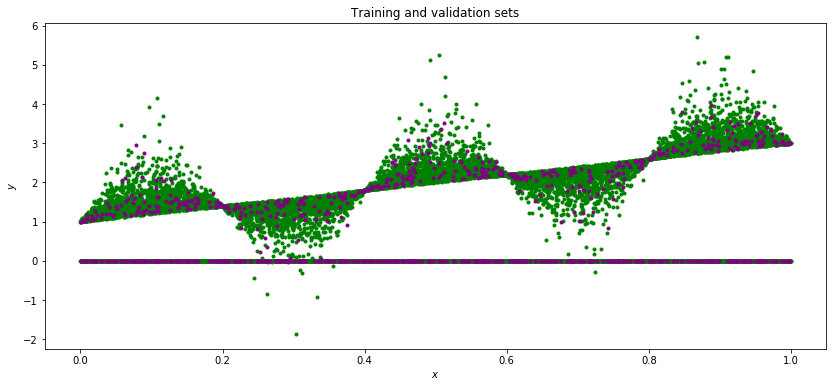

In [21]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Training and validation sets')
plt.plot(x, y, '.', color= 'green')
plt.plot(x_val, y_val, '.', color='purple')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [22]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.cuda.FloatTensor
x_t = Variable(torch.from_numpy(x).type(dtype))
y_t = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x_t.shape, y_t.shape

(torch.Size([9500, 1]), torch.Size([9500, 2]))

In [23]:
model_2 = TwoLayer_Network(input_size, hidden_size, output_size).cuda()

In [24]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

In [25]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model_1(x_t)
    
    # Calculate loss
    loss = loss_variance_error(y_pred, y_t)
    if i%500 == 0: print(f'epoch: {i:4} loss: {loss.data.item():.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0 loss: 0.194
epoch:  500 loss: 0.162
epoch: 1000 loss: 0.142
epoch: 1500 loss: 0.125
epoch: 2000 loss: 0.111
epoch: 2500 loss: 0.102
epoch: 3000 loss: 0.0957
epoch: 3500 loss: 0.0921
epoch: 4000 loss: 0.0901
epoch: 4500 loss: 0.0888
epoch: 5000 loss: 0.0881
epoch: 5500 loss: 0.0877
epoch: 6000 loss: 0.0875
epoch: 6500 loss: 0.0874
epoch: 7000 loss: 0.0873
epoch: 7500 loss: 0.0872
epoch: 8000 loss: 0.0871
epoch: 8500 loss: 0.0871
epoch: 9000 loss: 0.0871
epoch: 9500 loss: 0.0871


In [26]:
# Get predicted y and sigma for validation set
x_val_t = Variable(torch.from_numpy(x_val).type(dtype)) 
pred_1 = model_1(x_val_t)

# prediction of the response variables
y_pred_1 = pred_1[:,0].cpu().data
sigma_pred_1 = pred_1[:,1].cpu().data

C:\Users\yolan\Anaconda3\envs\deep_learning_pytorch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


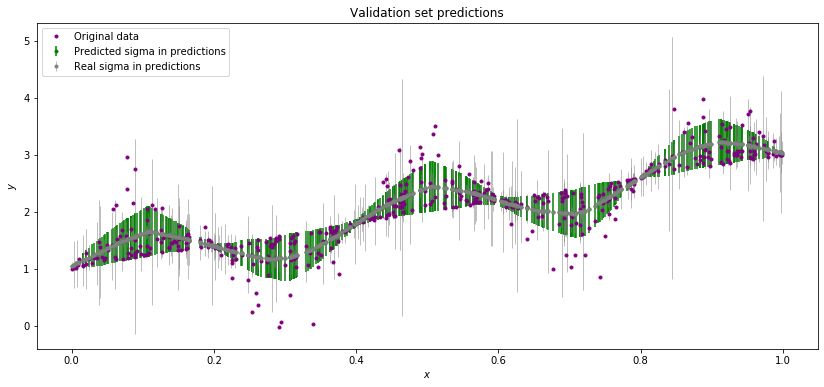

In [27]:
# Plot predictions and their errors
plot_regression_uncertainty(x_val, y_val, y_pred_1, sigma_pred_1, real_sigma_1)

Here, we find a strange effect. We were expecting to not be able to approximate an assymetric distribution. In fact, we didn't do ot. This plot seems correct because the model is overffitted and learning from noise. We already know that the underlying function is linear, however the model learns the sinusoidal noise. Thus, we are plotting **a symmetric error** in a sinusoidal function

### Experiment 3

> **H3**: Are we able to approximate a non-constant uncertainty and target covariance?

We will increment the number of data points and generate both the noise and x using a exponential distribution. Using a exponential the covariance of the error and target condicitioned to X will decrease exponentially

In [28]:
# Generate some linearly related data
np.random.seed(2019)

n_samples = 100000
x = np.random.exponential(scale=5.0,size=n_samples)

sin_ =  np.sin(x*2*np.pi)
eps = np.random.exponential(scale=5.0, size=n_samples) * sin_ # noise
y_1 = 2*x + 1 
y = y_1 + eps # linear data with noise

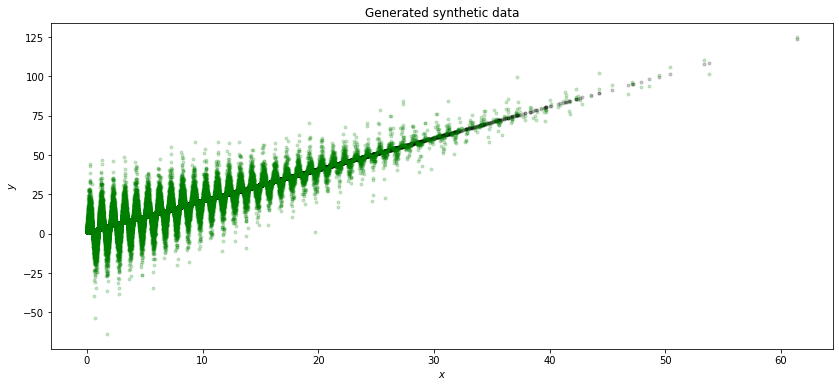

In [29]:
# Plot the data
plot_regression_dataset(x, y, y_1, 'Generated synthetic data')

In [30]:
x_val, x,  y_val, y = data_preparation(x, y, n_validation=500)

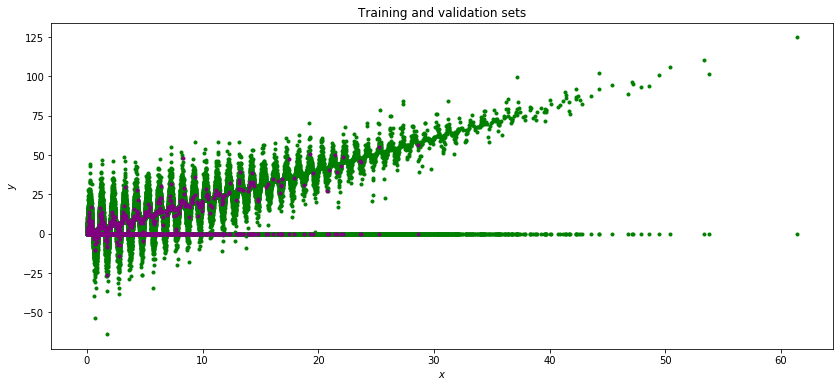

In [31]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Training and validation sets')
plt.plot(x, y, '.', color= 'green')
plt.plot(x_val, y_val, '.', color='purple')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [32]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.cuda.FloatTensor
x_t = Variable(torch.from_numpy(x).type(dtype))
y_t = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [33]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x_t.shape, y_t.shape

(torch.Size([99500, 1]), torch.Size([99500, 2]))

In [34]:
model_3 = TwoLayer_Network(input_size, hidden_size, output_size).cuda()

In [35]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

In [36]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model_3(x_t)
    
    # Calculate loss
    loss = loss_variance_error(y_pred, y_t)
    if i%500 == 0: print(f'epoch: {i:4} loss: {loss.data.item():.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0 loss: 1.15e+06
epoch:  500 loss: 2.98e+03
epoch: 1000 loss: 2.69e+03
epoch: 1500 loss: 2.62e+03
epoch: 2000 loss: 2.59e+03
epoch: 2500 loss: 2.57e+03
epoch: 3000 loss: 2.55e+03
epoch: 3500 loss: 2.54e+03
epoch: 4000 loss: 2.52e+03
epoch: 4500 loss: 2.5e+03
epoch: 5000 loss: 2.48e+03
epoch: 5500 loss: 2.47e+03
epoch: 6000 loss: 2.46e+03
epoch: 6500 loss: 2.44e+03
epoch: 7000 loss: 2.43e+03
epoch: 7500 loss: 2.41e+03
epoch: 8000 loss: 2.4e+03
epoch: 8500 loss: 2.39e+03
epoch: 9000 loss: 2.37e+03
epoch: 9500 loss: 2.36e+03


In [37]:
# Get predicted y and sigma for validation set
x_val_t = Variable(torch.from_numpy(x_val).type(dtype)) 
pred_1 = model_3(x_val_t)

# prediction of the response variables
y_pred_1 = pred_1[:,0].cpu().data
sigma_pred_1 = pred_1[:,1].cpu().data

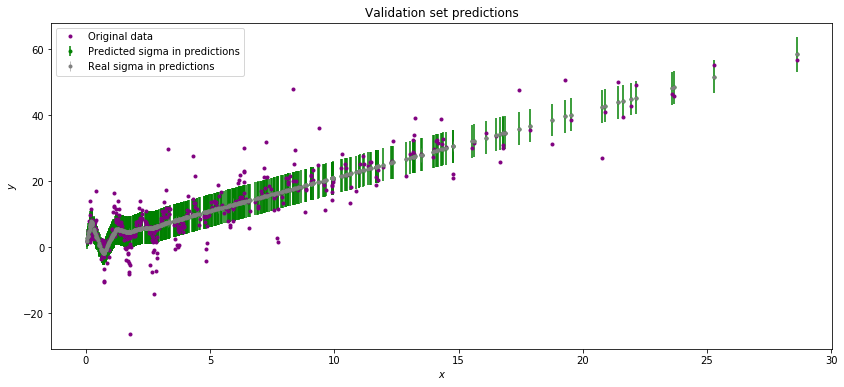

In [38]:
plot_regression_uncertainty(x_val, y_val, y_pred_1, sigma_pred_1, real_sigma_1)

Here, we see that the variance of the error remains constant in most of the plot. We were expecting an exponential decrease of the variance

(0, 5)

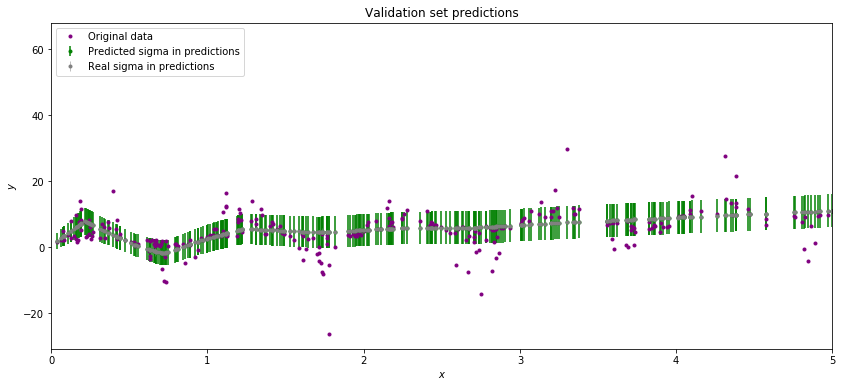

In [42]:
plot_regression_uncertainty(x_val, y_val, y_pred_1, sigma_pred_1, real_sigma_1)
plt.xlim(0,5)

### Is it the predicted variance error distribution equals to the real variance error distirbution?

#### Predicted variance error distribution

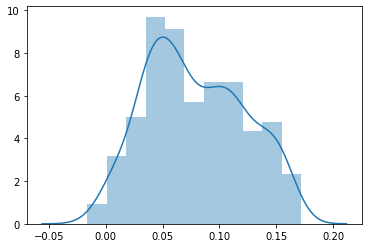

In [17]:
import seaborn as sns
sns.distplot(sigma_pred_1)

#### Generated error distribution

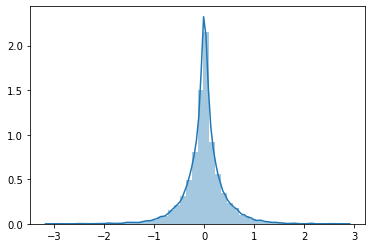

In [18]:
sns.distplot(eps)

#### Real variance error distribution 

In [20]:
real_sigma = (y_pred_1.numpy()- y_val[:,0])**2

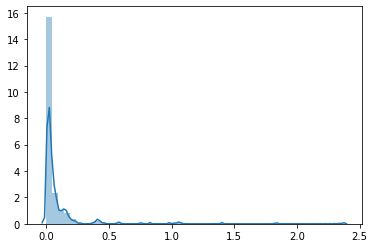

In [21]:
sns.distplot(real_sigma)

### Are the two (real and predicted error variance) distributions the same?

#### Statistical tests to affirm the assumption extraced from plots 

In [33]:
from scipy import stats

#### Normality check with p-p plot and saphiro test

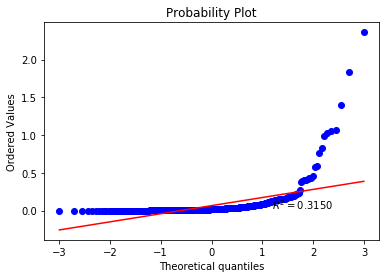

In [42]:
stats.probplot(real_sigma, fit=True, rvalue=True, plot=plt);

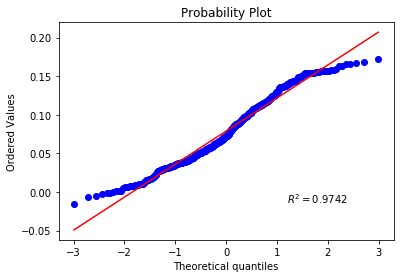

In [35]:
stats.probplot(sigma_pred_1, fit=True, rvalue=True, plot=plt);

In [36]:
stats.shapiro(sigma_pred_1)

(0.9720467925071716, 3.579397045427868e-08)

Comparing the two distributions with Kolmogorov-Smirnov

In [38]:
stats.ks_2samp(sigma_pred_1, real_sigma)

Ks_2sampResult(statistic=0.522, pvalue=1.4765110719589765e-62)

We can reject the null hypothesis: the two distribution are not identical

### Conclusions

- **H1**: The estimated variance distribution usually is smoothed when the error is generated with a non-gaussian distribution
- **H2**: We might easily overfit the dataset with this model. It is not possible to estimate an asymmetric variance distribution 
- **H3**: This method requires a correlation in the uncertainty over the x-axis

Additionally, we have tried to change the loss function without success, we have experiented covergence problems. The trial of calculation of the parameters of the exponential distribution using MLE is included in this file:

https://docs.google.com/document/d/1DkcUwaWw3lTW_1ylt3POmfGURaD08xCuaUBYcRnc_5U/edit

One advantage of the gaussian distribution is that it has good mathematical properties to ease its computation 

Finally, we conclude that this method **has its limitations to model non symmetric distributions**. Additionally, It is **difficult to change the loss function** even if we are confidence about the data distribution type